# Denoising AutoEncoder

We will build a Denoising-AutoEncoder to filter the noise in Images

### Imports

#### Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import argparse
import cv2
from tensorflow.keras.layers import BatchNormalization,Conv2D,Conv2DTranspose,LeakyReLU,Activation,Flatten,Dense,Reshape,Input,Concatenate
from tensorflow.keras.initializers import orthogonal
from tensorflow.keras.models import Model,load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Connecting Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My\ Drive/Machine-Learning-Projects/Denoising\ Images/Dataset

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Machine-Learning-Projects/Denoising Images/Dataset


#### Downloading Dataset



In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2020-08-07 19:18:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

cats_and_dogs_filte 100%[===================>]  65.43M  57.0MB/s    in 1.1s    

2020-08-07 19:18:02 (57.0 MB/s) - ‘cats_and_dogs_filtered.zip.2’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

zip_ref = zipfile.ZipFile("cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall()
zip_ref.close()
  
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [ ]:
os.chdir("/gdrive/My Drive/Machine-Learning-Projects/Denoising Images")

### Dataset

#### Output Data



In [ ]:
def ReadDataset(ImagePath='Dataset/cats_and_dogs_filtered/train/'):
    Y_Train = []

    Dogs = os.listdir(ImagePath + "dogs")

    Files = []

    for i in Dogs:
        Files.append(ImagePath + "dogs/" + i)

    i = 0;
    for f in Files:
        # Reading Image
        img = Image.open(f)
        img = img.resize((256,256))
        img = np.array(img)/255.0

        Y_Train.append(img)
        i += 1

        if (i%250 == 0 and i>0):
            print (str(i) + " Images are Processed")

    return np.array(Y_Train)

In [ ]:
Y_Train = ReadDataset()

250 Images are Processed
500 Images are Processed
750 Images are Processed
1000 Images are Processed


#### Input Data

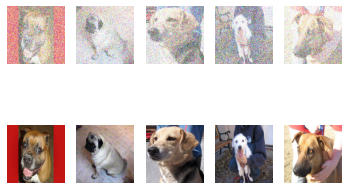

In [ ]:
X_Train_Noise = np.random.normal(loc=0.5, scale=0.5, size=Y_Train.shape)

X_Train = np.clip(Y_Train + X_Train_Noise,0,1)

# Plotting Data
for i in range(10):
	plt.subplot(2, 5, 1 + i)
	plt.axis('off')
	if i<5:
		plt.imshow((X_Train[i]))
	else:
		plt.imshow((Y_Train[i-5]))
plt.show()

### Model

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 32)                8408416   
_________________________________________________________________
Decoder (Functional)         (None, 256, 256, 3)       8707395   
Total params: 17,115,811
Trainable params: 17,115,427
Non-trainable params: 384
_________________________________________________________________
None


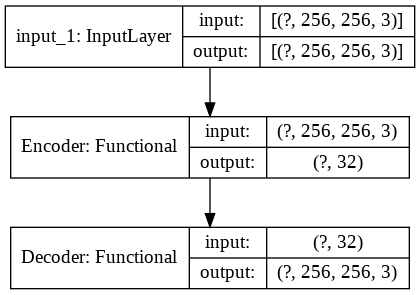

In [ ]:
class DAE():
	@staticmethod
	def buildmodel(height,width,depth,filters=(32,64),latentDim=32):
		
		# Encoder Architecture
		inputs = Input(shape=(height,width,depth))
		x = inputs
		for f in filters:
			x = Conv2D(f, (3,3), strides=2, padding='same')(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=-1)(x)
			
		volumeSize = tf.keras.backend.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		
		# Encoder Model
		Encoder = Model(inputs,latent,name="Encoder")
		
		
		# Decoder Architecture
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1],volumeSize[2],volumeSize[3]))(x)
		for f in filters[::-1]:
			x = Conv2DTranspose(f, (3,3), strides=2, padding='same')(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=-1)(x)
		x = Conv2DTranspose(depth, (3,3), padding='same')(x)
		output = Activation("sigmoid")(x)
		
		# Decoder Model
		Decoder = Model(latentInputs,output,name="Decoder")
		
		# Encoder and Decoder --> AutoEncoder
		AutoEncoder = Model(inputs,Decoder(Encoder(inputs)),name="AutoEncoder")
		
		return (Encoder,Decoder,AutoEncoder)
		
dae = DAE()
Encoder,Decoder,AutoEncoder = dae.buildmodel(256,256,3)
print (AutoEncoder.summary())
tf.keras.utils.plot_model(Encoder, to_file='Images/Encoder.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(Decoder, to_file='Images/Decoder.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(AutoEncoder, to_file='Images/AutoEncoder.png', show_shapes=True, show_layer_names=True)

### Training Model

Epoch 1/200
13/13 [==============================] - 3s 263ms/step - loss: 0.0726 - val_loss: 0.0722
Epoch 2/200
13/13 [==============================] - 3s 221ms/step - loss: 0.0458 - val_loss: 0.1542
Epoch 3/200
13/13 [==============================] - 3s 222ms/step - loss: 0.0401 - val_loss: 0.1465
Epoch 4/200
13/13 [==============================] - 3s 222ms/step - loss: 0.0364 - val_loss: 0.0872
Epoch 5/200
13/13 [==============================] - 3s 217ms/step - loss: 0.0334 - val_loss: 0.0832
Epoch 6/200
13/13 [==============================] - 3s 219ms/step - loss: 0.0313 - val_loss: 0.0772
Epoch 7/200
13/13 [==============================] - 3s 223ms/step - loss: 0.0295 - val_loss: 0.0618
Epoch 8/200
13/13 [==============================] - 3s 220ms/step - loss: 0.0282 - val_loss: 0.0548
Epoch 9/200
13/13 [==============================] - 3s 219ms/step - loss: 0.0268 - val_loss: 0.0484
Epoch 10/200
13/13 [==============================] - 3s 216ms/step - loss: 0.0258 - val_lo

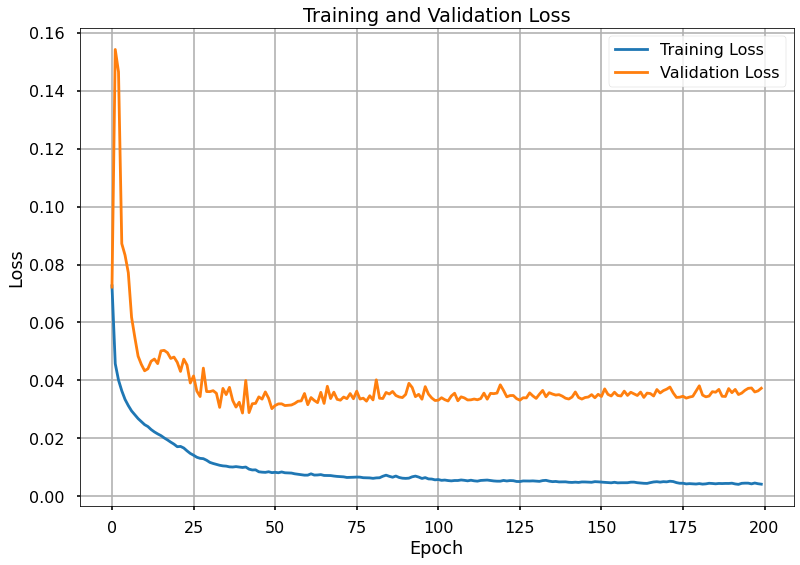

In [ ]:
AutoEncoder.compile(loss='mse', optimizer='adam')
Epochs=200
Batch_Size=64

Train_History = AutoEncoder.fit(X_Train,Y_Train,validation_split=0.2,epochs=Epochs,batch_size=Batch_Size)
AutoEncoder.save("Models/DAE_Model.h5")

# Plotting Train Results
N = np.arange(Epochs)
plt.style.use("seaborn-poster")
plt.figure()
plt.grid()
plt.plot(N, Train_History.history["loss"], label="Training Loss")
plt.plot(N, Train_History.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.savefig("Images/Loss.png")

### Testing

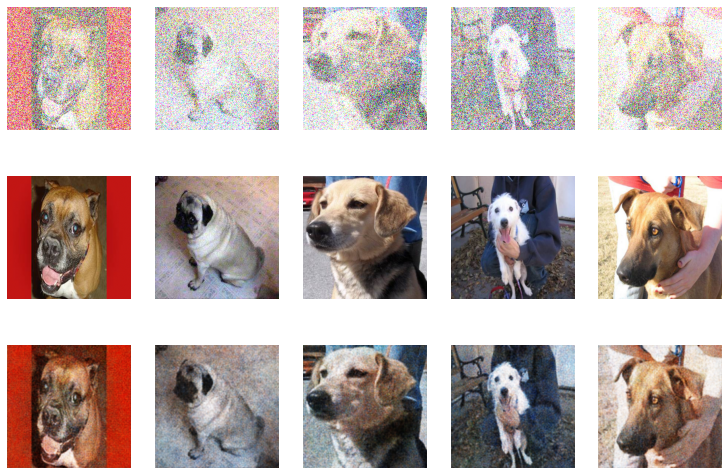

In [ ]:
AutoEncoder = load_model('Models/DAE_Model.h5')
for i in range(15):
	plt.subplot(3, 5, 1 + i)
	plt.axis('off')
	if i<5:
		plt.imshow((X_Train[i]))
	elif i<10 and i>=5:
		plt.imshow((Y_Train[i-5]))
	else:
		X = np.expand_dims(X_Train[i-10],axis=0)
		Y = AutoEncoder.predict(X)
		Y = Y[0]
		plt.imshow(Y)
		
plt.savefig("Images/Results.png")
plt.show()